In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 12 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 1
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon)
Y_hat_df.head(5)

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-31,146.062103,144.227417,141.458542,136.714539
AMZN,2023-01-31,101.099319,103.128082,95.366661,98.909363
BTC-USD,2023-01-31,24890.154297,23138.625000,23310.355469,23904.435547
GOOGL,2023-01-31,97.816597,99.128014,95.094780,96.681313
IBM,2023-01-31,126.279427,127.312721,125.773720,126.703262


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
        mae       mse      mape      rmse    smape:
0  0.143417  0.020569  0.000981  0.143417  0.098141

Model: AutoETS
        mae       mse     mape      rmse    smape:
0  1.978104  3.912894  0.01353  1.978104  1.362176

Model: AutoTheta
        mae        mse      mape      rmse    smape:
0  4.746979  22.533807  0.032468  4.746979  3.300363

Model: CES
        mae       mse      mape      rmse    smape:
0  9.490982  90.07874  0.064915  9.490982  6.709303

Results for MSFT:
Model: AutoARIMA
        mae        mse      mape      rmse    smape:
0  5.298767  28.076933  0.021511  5.298767  2.174497

Model: AutoETS
        mae       mse      mape      rmse    smape:
0  1.058975  1.121429  0.004299  1.058975  0.430832

Model: AutoTheta
        mae        mse      mape      rmse    smape:
0  9.892685  97.865215  0.040161  9.892685  4.098372

Model: CES
        mae        mse      mape      rmse    smape:
0  3.168045  10.036509  0.012861  3.168045  1.294437

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=1, n_windows=3, step_size=1, level=[99])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-11-01,2022-10-01,146.577271,160.892242,150.333389,171.451096,153.152954,108.345383,197.960541,153.037582,144.084976,162.172333,158.549225,142.751862,173.144363
AAPL,2022-12-01,2022-11-01,128.868332,149.667770,138.924469,160.411072,147.789139,104.617645,190.960617,144.085251,135.302383,153.046799,150.753601,135.621384,165.900040
AAPL,2023-01-01,2022-12-01,143.110992,127.126007,115.795486,138.456528,129.764267,91.838348,167.690186,128.442841,119.526993,137.540070,129.072113,112.797676,145.671677
AMZN,2022-11-01,2022-10-01,96.540001,103.465332,89.651863,117.278793,102.441055,67.159676,137.722443,106.442215,93.458702,119.689880,106.537193,87.176468,126.324585
AMZN,2022-12-01,2022-11-01,84.000000,97.058662,83.228859,110.888458,96.540588,63.341442,129.739746,92.945381,80.567169,105.575439,97.421272,78.551247,116.309044


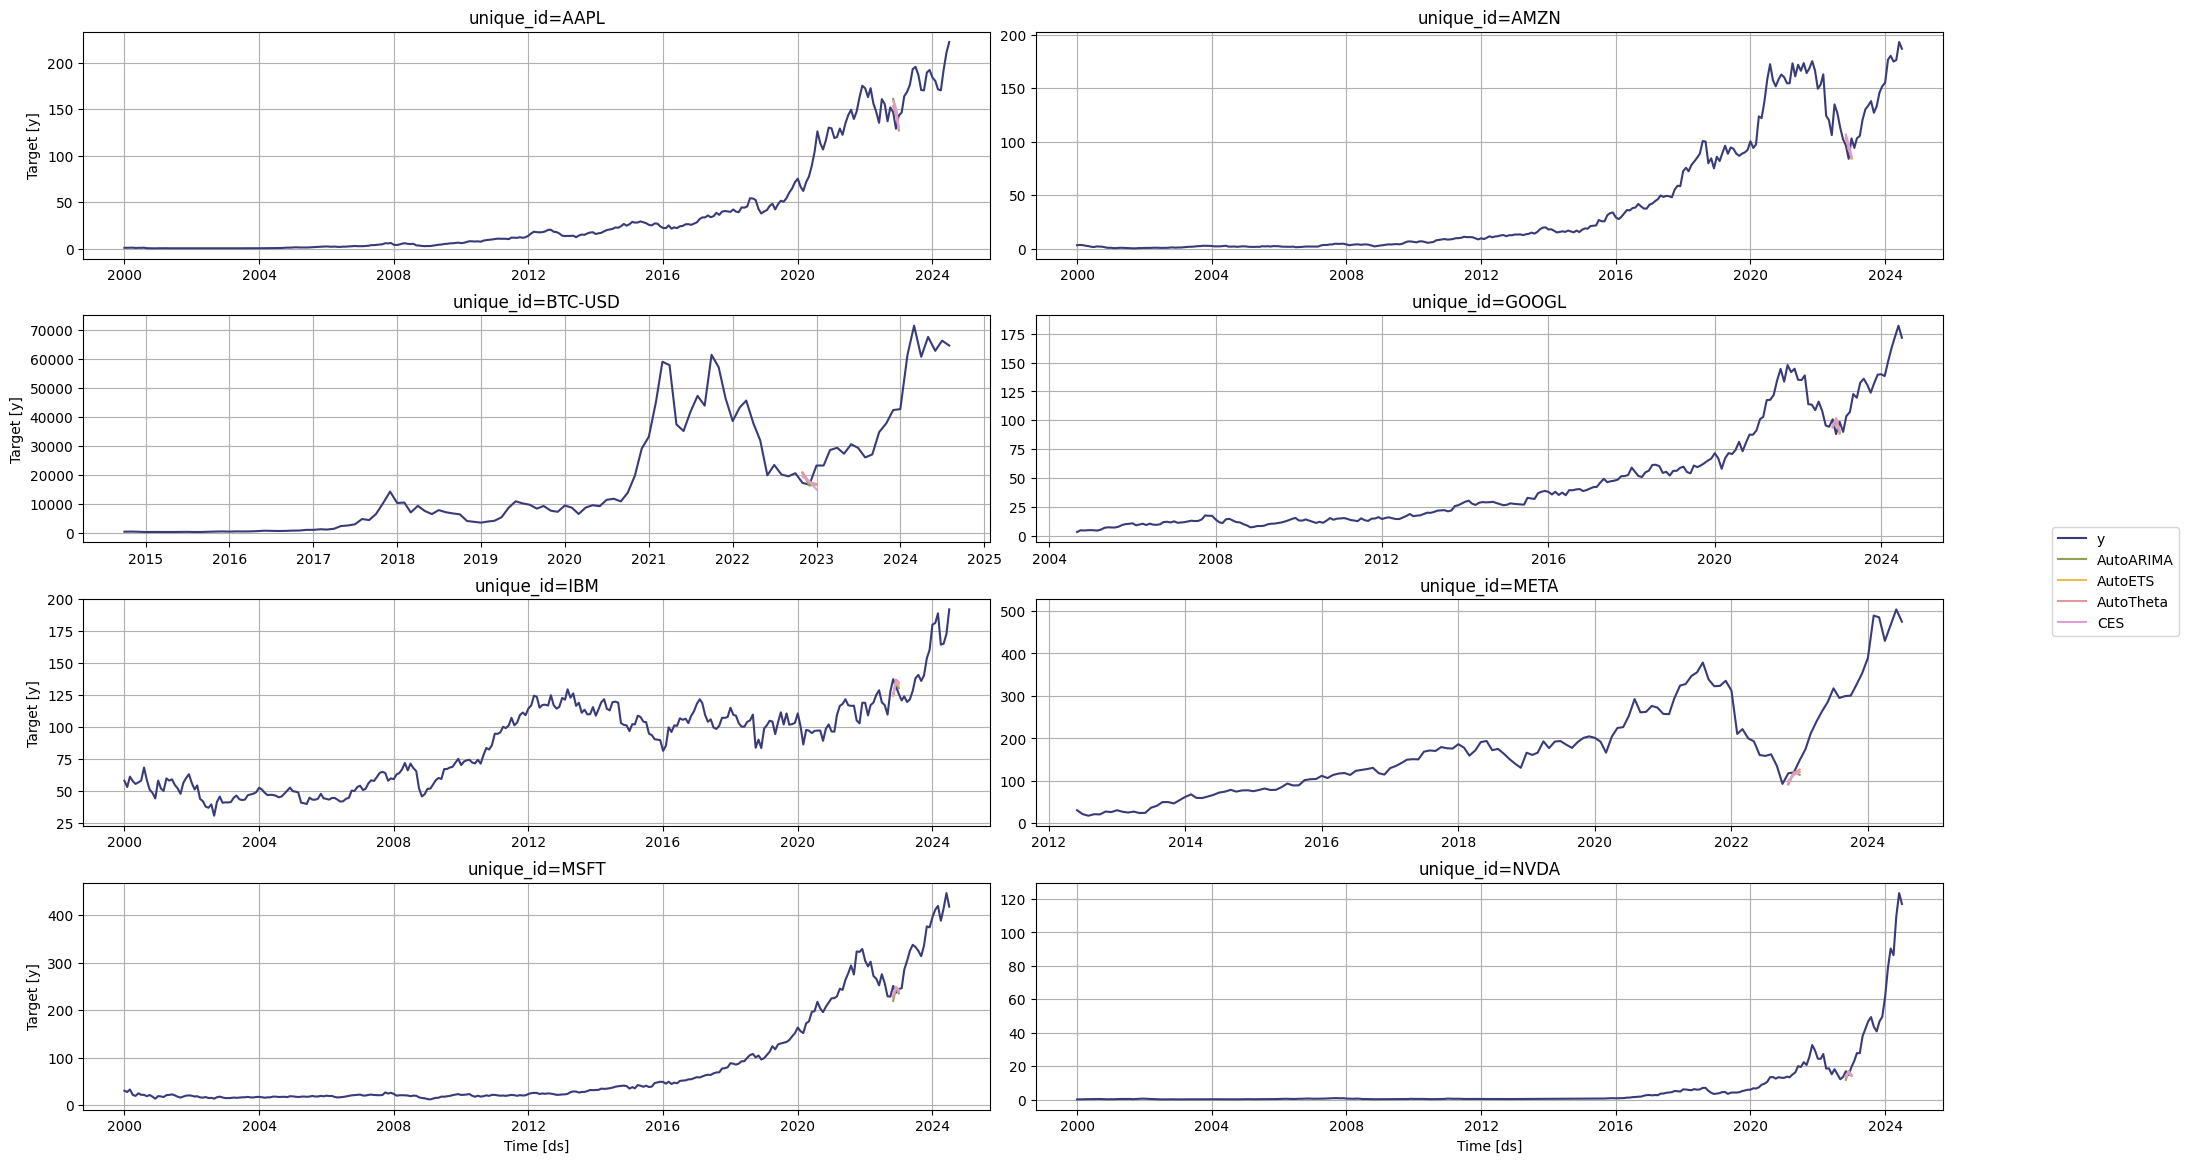

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))